In [1]:
import re

import pandas as pd
import re, string
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter
from multiprocessing import Pool
from urllib.parse import urlparse

%matplotlib inline

In [2]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer, MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression

In [3]:
path = Path('Data/')

In [4]:
df = pd.read_feather('Data/May2015_subset.fthr')

/home/gokul/anaconda3/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


In [5]:
df.subreddit.value_counts()

leagueoflegends      1223184
funny                 745916
news                  548287
todayilearned         519910
worldnews             490354
movies                376601
gaming                361265
politics              244927
explainlikeimfive     223148
anime                 221118
gameofthrones         191006
motorcycles            89721
science                89413
conspiracy             78349
tf2                    76549
sex                    74912
guns                   61234
comicbooks             60303
pokemon                59730
food                   55231
starcraft              53797
askscience             53017
mylittlepony           44119
space                  42726
skyrim                 40568
circlejerk             30134
facepalm               22562
community              20635
harrypotter            19998
progresspics           13385
drunk                  13027
startrek               12275
thewalkingdead         10357
offbeat                10035
lifehacks     

In [6]:
subreddit_list = ['worldnews', 'movies', 'gaming', 'science', 'food']

In [7]:
df = df[df.subreddit.isin(subreddit_list)]

In [8]:
df.shape

(1372864, 22)

In [10]:
df['subreddit'] = df.subreddit.astype('category')
df['subreddit_id'] = df.subreddit_id.astype('category')
df['distinguished'] = df.distinguished.astype('category')
df['link_id'] = df.link_id.astype('category')

df.drop(['archived', 'retrieved_on', 'id',
         'author_flair_css_class', 'author_flair_text',
         'removal_reason'], axis=1, inplace=True)

In [9]:
df.distinguished.replace(to_replace=np.NaN, value='user', inplace=True)

In [10]:
df.columns

Index(['created_utc', 'ups', 'subreddit_id', 'link_id', 'name', 'score_hidden',
       'author_flair_css_class', 'author_flair_text', 'subreddit', 'id',
       'removal_reason', 'gilded', 'downs', 'archived', 'author', 'score',
       'retrieved_on', 'body', 'distinguished', 'edited', 'controversiality',
       'parent_id'],
      dtype='object')

In [11]:
f"{df.memory_usage(deep=True).sum() / 1023.0**3} GB"

'1.1661081546498158 GB'

In [12]:
assert len(df.subreddit_id.unique()) == len(df.subreddit.unique())

In [13]:
df.subreddit.value_counts()

worldnews    490354
movies       376601
gaming       361265
science       89413
food          55231
Name: subreddit, dtype: int64

In [14]:
df['time'] = pd.to_datetime(df.created_utc, unit='s')

In [15]:
df_first_comment = df[['link_id', 'time']].groupby(by=['link_id']).min()

In [16]:
df_first_comment.shape

(46546, 1)

In [17]:
df_first_comment_dict = df_first_comment.to_dict('index')

In [18]:
def time_lapse(x):
    return df_first_comment_dict[x]['time']

In [19]:
df['time_lapse'] = df.time - df.link_id.apply(time_lapse)

In [20]:
df.time_lapse = df.time_lapse.apply(lambda x: x.total_seconds())

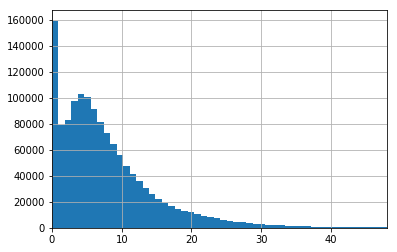

In [21]:
(df.time_lapse / (60*60)).hist(bins=800).set_xlim((0, 48));

In [3]:
def pd_to_dict(df, index='', column=''):
    return pd.Series(df[column].values, index=df[index]).to_dict()

In [23]:
comment_to_parent_dict = pd_to_dict(df[['name', 'parent_id']],
                                    index='name', column='parent_id')

In [24]:
len(comment_to_parent_dict)

1372864

In [25]:
def get_depth(x):
    counter = 0
    temp = x
    while True:
        if temp[:3] == 't3_':
            return counter
        try:
            temp = comment_to_parent_dict[temp]
        except KeyError:
            return np.nan
        counter += 1

In [26]:
df['depth'] = df['name'].apply(get_depth)

In [27]:
df.depth.isna().sum() / float(df.shape[0])

0.01057424479045266

In [28]:
df['linked_sr'] = df.body.apply(lambda x: re.findall(r"/r/([^\s/]+)", x))

In [29]:
df['body'] = df.body.apply(lambda x: re.sub(r"(/r/[^\s/]+)", '', x))

In [30]:
url_regex = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'

In [31]:
def get_domains(x):
    x = x.replace(' = ', '=')
    x = x.replace(' : ', ':')
    x = x.replace(' / ', '?')
    urls = re.findall(url_regex, x)
    try:
        domain_names = [urlparse(url).netloc.split('.')[-2] for url in urls]
    except:
        return []
    return domain_names

In [32]:
df['linked_urls'] = df.body.apply(lambda x: get_domains(x))

In [33]:
def remove_urls(x):
    x = x.replace(' = ', '=')
    x = x.replace(' : ', ':')
    x = x.replace(' / ', '?')
    return re.sub(url_regex, '', x)

In [34]:
df['body'] = df.body.apply(lambda x: remove_urls(x))

In [35]:
df['no_of_linked_sr'] = df['linked_sr'].apply(lambda x: len(x))
df['no_of_linked_urls'] = df['linked_urls'].apply(lambda x: len(x))

In [36]:
all_linked_sr = []
for l in df.linked_sr.values:
    all_linked_sr += l
len(all_linked_sr)

35356

In [37]:
top_sr_links = Counter(all_linked_sr)
top_sr_links.most_common(20)

[('worldnews', 4946),
 ('worldnews)', 2796),
 ('worldnews.', 2489),
 ('help', 2387),
 ('worldnews](http:', 2387),
 ('food),', 1594),
 ('gaming', 1435),
 ('food)', 1283),
 ('movies', 1225),
 ('science', 1044),
 ('movies)', 467),
 ('EverythingScience.', 459),
 ('AutoModerator', 452),
 ('conspiracy', 241),
 ('science.', 206),
 ('movies.', 191),
 ('Movies', 176),
 ('food', 174),
 ('nottheonion', 156),
 ('science)', 136)]

Should not probably use the actual names.

In [38]:
all_linked_urls = []
for l in df.linked_urls.values:
    all_linked_urls += l
len(all_linked_urls)

106993

In [39]:
top_url_links = Counter(all_linked_urls)
top_url_links.most_common(15)

[('reddit', 20232),
 ('youtube', 14216),
 ('wikipedia', 11078),
 ('imgur', 8154),
 ('youtu', 3616),
 ('redditblog', 2393),
 ('imdb', 2132),
 ('co', 1811),
 ('theguardian', 823),
 ('google', 733),
 ('github', 606),
 ('wordpress', 556),
 ('nytimes', 508),
 ('twitter', 432),
 ('amazon', 425)]

In [40]:
allowed_urls = [i[0] for i in top_url_links.most_common(15)]

In [41]:
def remove_urls(x):
    y = []
    for i in x:
        if i in allowed_urls:
            y += [i]
    return y

In [42]:
df['a_linked_urls'] = df['linked_urls'].apply(lambda x: remove_urls(x))

Small I doesn't work for subjectivity

In [43]:
df['subjectivity'] = df['body'].str.count('I ')

In [44]:
df['is_edited'] = df.edited.apply(lambda x: x > 0)

In [45]:
f"{df.memory_usage(deep=True).sum() / 1023.0**3} GB"

'1.4112581959444024 GB'

To check if the comment is quotes another comment.

In [46]:
# if the comment is qouted
df['is_quoted'] = df.body.str.contains('&gt;')

In [47]:
df['no_quoted'] = df.body.str.count('&gt;')

In [48]:
comment_to_score = pd_to_dict(df[['name', 'score']],
                              index='name', column='score')

In [49]:
def get_parent_score(x):
    try:
        return comment_to_score[x]
    except:
        return 0

In [50]:
df['parent_score'] = df.parent_id.apply(lambda x: get_parent_score(x))

In [51]:
comment_to_time = pd_to_dict(df[['name', 'time']],
                              index='name', column='time')

In [52]:
def get_time_since_parent(pi):
    try:
        return comment_to_time[pi]
    except:
        return np.nan

In [53]:
df['time_since_parent'] = df.parent_id.apply(get_time_since_parent)

In [54]:
df.loc[df.time_since_parent.isna(), 'time_since_parent'] = df.time

In [55]:
df.time_since_parent = df.time - df.time_since_parent

In [56]:
df.time_since_parent = df.time_since_parent.apply(lambda x: x.total_seconds())

In [57]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

/home/gokul/anaconda3/lib/python3.6/site-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.24.1) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [58]:
analyser = SentimentIntensityAnalyzer()

In [59]:
def get_sentiment(x):
    return analyser.polarity_scores(x)

In [4]:
num_partitions = 100
num_cores = 6

In [5]:
def parallelize_dataframe(df, func):
    df_split = np.array_split(df, num_partitions)
    pool = Pool(num_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

In [62]:
def wrapper_get_sentiment(df):
    df['sentiment'] = df['body'].apply(get_sentiment)
    return df

In [63]:
sentiment = parallelize_dataframe(df['body'].to_frame(), wrapper_get_sentiment)

In [64]:
sentiment.drop(['body'], axis=1, inplace=True)

In [65]:
df['senti_neg'] = sentiment['sentiment'].apply(lambda x: x['neg'])
df['senti_neu'] = sentiment['sentiment'].apply(lambda x: x['neu'])
df['senti_pos'] = sentiment['sentiment'].apply(lambda x: x['pos'])
df['senti_comp'] = sentiment['sentiment'].apply(lambda x: x['compound'])

In [66]:
del sentiment

In [95]:
df.to_pickle('Data/working_sub.pkl')

In [79]:
df = pd.read_pickle('Data/working_sub.pkl')

In [86]:
df.parent_id[df.parent_id.str.startswith('t3_')].unique().shape

(45400,)

In [7]:
df.shape

(1372864, 34)

In [7]:
# sub_punct = lambda x: re.sub(r'['+string.punctuation+']+', ' ', x)
# df['body'] = df['body'].apply(sub_punct)

In [8]:
def get_word_count(df):
    df['word_count'] = df['body'].apply(lambda x: len(x.split()))
    return df

In [9]:
word_counts = parallelize_dataframe(df['body'].to_frame(), get_word_count)
df['word_counts'] = word_counts.word_count

In [10]:
del word_counts

In [11]:
import string

In [12]:
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS

In [13]:
table = str.maketrans({key: ' ' for key in string.digits + string.punctuation + '\t\n\r'})

In [18]:
def load_glove(filename):
    glove = {}
    with open(filename, 'r') as read_file:
        for line in read_file:
            key = line.split(' ')[0]
            vector = np.array(line.split(' ')[1:], dtype=np.float)
            glove[key] = vector

    return glove

In [14]:
def words(text):
    text = text.lower()
    text = text.translate(table).strip()
    terms = text.split(' ')
    terms = [t for t in terms if len(t) > 2]
    terms = [t for t in terms if t not in ENGLISH_STOP_WORDS]

    return terms

In [16]:
def get_doc2vec(text, gloves):
    count_words = 0
    final_vector = 0
    terms = words(text)

    for t in terms:
        if t in gloves.keys():
            count_words += 1
            final_vector += gloves[t]
    if count_words != 0:
        return final_vector / count_words
    else:
        return None

In [19]:
# gloves = load_glove('Data/glove.6B.50d.txt')
gloves = load_glove('Data/glove.twitter.27B.200d.txt')

In [20]:
def wrapper_get_centroid(df):
    df['doc2vec'] = df['body'].apply(lambda x: get_doc2vec(x, gloves))
    return df

In [21]:
doc2vec = parallelize_dataframe(df['body'].to_frame(), wrapper_get_centroid)

In [22]:
doc2vec = doc2vec.doc2vec.values

In [23]:
df['doc2vec'] = doc2vec

In [83]:
del gloves

In [84]:
del doc2vec

In [24]:
comment_to_body = pd_to_dict(df[['name', 'body']],
                                index='name', column='body')
comment_to_parent = pd_to_dict(df[['name', 'parent_id']],
                                index='name', column='parent_id')

In [25]:
def get_cosine_angle(cmnt_id):
    child = comment_to_body[cmnt_id]
    try:
        parent = comment_to_body[comment_to_parent[cmnt_id]]
    except KeyError:
        return None
    child = get_doc2vec(child, gloves)
    parent = get_doc2vec(parent, gloves)
    if child is None:
        return None
    if parent is None:
        return None
    return child.dot(parent)

In [26]:
import gc

In [27]:
gc.collect()

42

In [28]:
df.name.values[-10:]

array(['t1_crrbdt2', 't1_crrbdtt', 't1_crrbdvn', 't1_crrbdxj',
       't1_crrbdxr', 't1_crrbebf', 't1_crrbecs', 't1_crrbedn',
       't1_crrbefm', 't1_crrbeft'], dtype=object)

In [30]:
get_cosine_angle('t1_crrbdvn')

12.462472865496432

In [31]:
def wrapper_get_cosine(df):
    df['cosine_angle'] = df['name'].apply(get_cosine_angle)
    return df

In [32]:
cosine_angle = parallelize_dataframe(df['name'].to_frame(), wrapper_get_cosine)

In [33]:
df['cos_angle'] = cosine_angle.cosine_angle

In [34]:
gc.collect()

7

In [28]:
# df.to_pickle('Data/working_sub_glove.pkl')

In [35]:
df.word_counts.quantile(0.99)

215.0

In [36]:
# remove comments that have  more than 500 words (outliers)
df = df[df['word_counts'] < 250]

In [37]:
df = df[~df.depth.isna()]

In [38]:
df.drop(['score_hidden'], axis=1, inplace=True)

In [39]:
df = df[df.body != '[deleted]']
df = df[df.body != '[removed]']
df = df[df.body != '']

In [40]:
df = df[~df.doc2vec.isna()]

In [41]:
df = df[~df.cos_angle.isna()]

In [42]:
df.shape

(834565, 36)

In [43]:
df.columns

Index(['created_utc', 'ups', 'subreddit_id', 'link_id', 'name', 'subreddit',
       'gilded', 'downs', 'author', 'score', 'body', 'distinguished', 'edited',
       'controversiality', 'parent_id', 'time', 'time_lapse', 'depth',
       'linked_sr', 'linked_urls', 'no_of_linked_sr', 'no_of_linked_urls',
       'a_linked_urls', 'subjectivity', 'is_edited', 'is_quoted', 'no_quoted',
       'parent_score', 'time_since_parent', 'senti_neg', 'senti_neu',
       'senti_pos', 'senti_comp', 'word_counts', 'doc2vec', 'cos_angle'],
      dtype='object')

In [44]:
df.drop(['doc2vec'], inplace=True, axis=1)

In [69]:
df.to_pickle('Data/temp.pkl')

In [6]:
df = pd.read_pickle('Data/temp.pkl')

In [45]:
f"{df.memory_usage(deep=True).sum() / 1023.0**3} GB"

'0.659080884564148 GB'

In [33]:
doc2vec = np.vstack([i for i in df.doc2vec.values])

In [49]:
np.save('Data/doc2vec.npy', doc2vec)

In [34]:
df.drop(['doc2vec'], inplace=True, axis=1)

In [46]:
df.columns

Index(['created_utc', 'ups', 'subreddit_id', 'link_id', 'name', 'subreddit',
       'gilded', 'downs', 'author', 'score', 'body', 'distinguished', 'edited',
       'controversiality', 'parent_id', 'time', 'time_lapse', 'depth',
       'linked_sr', 'linked_urls', 'no_of_linked_sr', 'no_of_linked_urls',
       'a_linked_urls', 'subjectivity', 'is_edited', 'is_quoted', 'no_quoted',
       'parent_score', 'time_since_parent', 'senti_neg', 'senti_neu',
       'senti_pos', 'senti_comp', 'word_counts', 'cos_angle'],
      dtype='object')

In [44]:
df.is_quoted.value_counts()

False    793966
True      47380
Name: is_quoted, dtype: int64

In [51]:
df.to_pickle('Data/working_sub_d2v.pkl')

In [5]:
df = pd.read_pickle('Data/working_sub_d2v.pkl')
doc2vec = np.load('Data/doc2vec.npy')

In [65]:
vectorizer = TfidfVectorizer(min_df=30)
#X_tfidf = vectorizer.fit_transform(df['body'])

In [47]:
numeric_cols = ['gilded', 'controversiality', 'time_lapse', 'depth', 'no_of_linked_sr',
                'no_of_linked_urls', 'subjectivity', 'no_quoted', 'parent_score',
                'senti_neg', 'senti_neu', 'senti_pos', 'senti_comp', 'word_counts',
                'time_since_parent', 'cos_angle']

In [48]:
from scipy.sparse import hstack

In [49]:
lb = LabelBinarizer()
mlb = MultiLabelBinarizer()

y = df.score.values
x = np.hstack((lb.fit_transform(df.subreddit),
               lb.fit_transform(df.distinguished),
               lb.fit_transform(df.is_edited),
               lb.fit_transform(df.is_quoted),
               mlb.fit_transform(df.a_linked_urls),
               df.loc[:, numeric_cols].values))
               #, doc2vec))

In [53]:
del df, doc2vec

In [54]:
np.random.seed(42)

In [55]:
x.shape

(834565, 41)

In [56]:
y.shape

(834565,)

In [57]:
np.isnan(x).shape

(834565, 41)

In [59]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2,
                                                    random_state=42)

Things to try:
1. Take cosine between the word to vec for past n comments
2. Remove the first comment
3. Try gradient boosting
4. Try getting topic infor
5. log transform

In [60]:
from sklearn.neighbors import KNeighborsRegressor

In [17]:
from sklearn.ensemble import RandomForestRegressor

In [62]:
from sklearn.ensemble import GradientBoostingRegressor

In [63]:
m = GradientBoostingRegressor(n_estimators=100, min_samples_leaf=10)
m.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=10,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [64]:
y_predicted = m.predict(X_test)
r2 = r2_score(y_test, y_predicted)
mse = mean_squared_error(y_test, y_predicted)
print(f"R-Sq: {r2:.4}")
print(f"RMSE: {np.sqrt(mse)}")

R-Sq: 0.2638
RMSE: 40.91939357206602


In [68]:
m = KNeighborsRegressor()
m.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=5, p=2,
          weights='uniform')

In [69]:
y_predicted = m.predict(X_test)
r2 = r2_score(y_test, y_predicted)
mse = mean_squared_error(y_test, y_predicted)
print(f"R-Sq: {r2:.4}")
print(f"RMSE: {np.sqrt(mse)}")

R-Sq: 0.08632
RMSE: 45.58570497618411


In [34]:
m = GradientBoostingRegressor(n_estimators=100, min_samples_leaf=10)
m.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=10,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
y_predicted = m.predict(X_test)
r2 = r2_score(y_test, y_predicted)
mse = mean_squared_error(y_test, y_predicted)
print(f"R-Sq: {r2:.4}")
print(f"RMSE: {np.sqrt(mse)}")

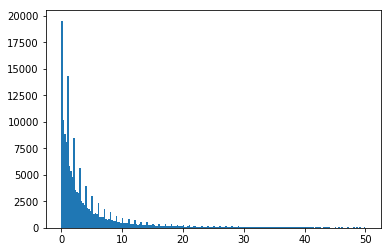

In [77]:
plt.hist(abs(y_test - y_predicted), bins=200, range=[0, 50]);

-------------

In [18]:
m = RandomForestRegressor(n_jobs=-1, n_estimators=40, min_samples_leaf=10)
m.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=10, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [19]:
y_predicted = m.predict(X_test)
r2 = r2_score(y_test, y_predicted)
mse = mean_squared_error(y_test, y_predicted)
print(f"R-Sq: {r2:.4}")
print(f"RMSE: {np.sqrt(mse)}")

R-Sq: 0.2748
RMSE: 44.08580527082157


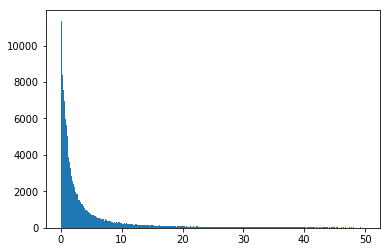

In [28]:
plt.hist(abs(y_test - y_predicted), bins=400, range=[0, 50]);

With raw child 50d glove - with just 10 estimaters

In [47]:
y_predicted = m.predict(X_test)
r2 = r2_score(y_test, y_predicted)
mse = mean_squared_error(y_test, y_predicted)
print(f"R-Sq: {r2:.4}")
print(f"RMSE: {np.sqrt(mse)}")

R-Sq: 0.1107
RMSE: 64.75655527375679


Result with just sentiment and parent score RandomForest 50 estimaters

In [121]:
y_predicted = m.predict(X_test)
r2 = r2_score(y_test, y_predicted)
mse = mean_squared_error(y_test, y_predicted)
print(f"R-Sq: {r2:.4}")
print(f"RMSE: {np.sqrt(mse)}")

R-Sq: 0.1425
RMSE: 60.66416993315583


In [20]:
m = LinearRegression()
m.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [21]:
y_predicted = m.predict(X_test)
r2 = r2_score(y_test, y_predicted)
mse = mean_squared_error(y_test, y_predicted)
print(f"R-Sq: {r2:.4}")
print(f"RMSE: {np.sqrt(mse)}")

R-Sq: 0.07293
RMSE: 66.1184751479385


In [ ]:
import pickle

In [ ]:
from joblib import dump, load

In [ ]:
dump(m, 'RF.joblib')